# ASTR 310 HW9

### 1. Time series analysis

In this problem you will perform a periodogram analysis of ten classical Cepheid variable stars in the Milky Way. Cepheids are a type of yellow supergiant star that expand and contract with a period that correlates with their average luminosity. The pulsation causes their brightness to change in a regular way.  The period of this pulsation can be directly measured, giving us the absolute magnitude of the star, and then if we also measure the apparent brightness, we can infer the star's distance.  The distances to nearby galaxies are most accurately estimated using these variable stars.

The relationship between absolute visual magnitude $M_V$ and period $P$ (in days) was determined for classical Cepheids using parallax measurements with the Hubble Space Telescope:
$$ M_V = (-2.43 \pm 0.12) (\log_{10} P - 1) - (4.05 \pm 0.02)$$
[Benedict et al. 2007, AJ, 133, 1810](https://ui.adsabs.harvard.edu/abs/2007AJ....133.1810B/abstract).  We will reproduce the sort of analysis that led to this fitting relationship.


**a)**  Download and extract `(tar xvfz)` the archive file `aavso_cepheids.tar.gz` from the class Canvas site. This archive contains ten files with time series data for different Cepheid stars from the American Association of Variable Star Observers (AAVSO) database. 

**b)** Loop over all of the Cepheids and analyze them as follows.

***i.*** For each Cepheid, read the corresponding file into an AstroPy Table. Each row contains
a separate observation of an apparent magnitude that can be in any one of several bands,
or even “Vis.” for human visual estimates. Create a Boolean mask array selecting on
the JD (Julian date) and Band columns. It should select rows that have Julian dates
later than 2440000 and observations in the visual band.

[7 pts]

***ii.*** The observations are not uniformly spaced in time. Using the Numpy interp()
function, interpolate the magnitude estimates onto a uniform grid of time values with
an interval of 1 day. The time values should range from the date of the first masked
observation to the last one for each Cepheid. For this task, you’ll need to first create
your uniform grid of time values (x desired) and then issue a command like the
following.

<samp>y_interp = np.interp(x_desired, x_known, y_known)<samp>

[7 pts]

***iii.*** For each Cepheid, compute and plot the Welch-filtered periodogram with overlapping
segments. There's an example in the PDF version of the assignment, if you want to know what yours should look like.

[7 pts]

***iv.*** Normalize the power spectra and remove the slope.   Specifically, note that the power spectrum consists of a power-law noise component with one or more peaks superimposed. We will take out the sloping noise component, and that will make the peak-finding more robust.

For each periodogram, find the array index corresponding to the smallest frequency larger than 0.003 $day^{-1}$. Compute the logarithmic slope of the line connecting the power spectrum value for this array index to the value in the last array index (ie. at the Nyquist frequency). 

Visually check to make sure that the slope you obtain roughly corresponds to the slope of the noise part of the power spectrum. An example for $\delta$ Cephei is shown in the PDF version of this assignment. The black dashed line has the desired slope; its normalization is off, but the slope is OK, and that's all we need now.  Later on in the course we will fit lines to data, and if you really want you could do that here too.  Note that the plot is logarithmic on both axes.

Next, divide the power spectrum by this line. You should obtain a flattened spectrum like the example shown in the PDF.

[7 pts]

_If this normalization step is giving you the heebie-jeebies, I suggest you skip it and continue with the rest of the analysis.  Your results shouldn't be too far off._

***v.*** Finally, determine the frequency corresponding to the
largest peak, ignoring frequencies smaller than 0.003 day$^{-1}$. (Galactic Cepheids have
periods less than 100 days.) Plot a line or a marker on the periodogram to verify that
your chosen frequency has indeed identified the highest peak in the periodogram.

[7 pts]

***vi.*** Save your results into an array containing the period values for the Cepheids.

[2 pts]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.table as table
import astropy.io.ascii as ascii
import os
import scipy

In [3]:
def welch(N_seg):
    welch = []
    for n in range(0, N_seg):
        wn = 1 - ((n - N_seg/2)/(N_seg/2))**2
        welch.append(wn)
    return np.array(welch)

def normalize(P, W, N_seg):
    return N_seg / np.sum(W**2) * P

def analyze_cepeid(filename):
    # read file
    t = ascii.read(f"aavso_cepheids/{filename}")

    # mask values
    mask = (t['JD'] > 2440000) & (t['Band'] == 'Vis.')

    # get masked arrays
    date = t['JD'][mask]
    mag = t['Magnitude'][mask]

    # get interpolated values
    y_interp = np.interp(np.arange(date.min(), date.max(), 1), date, mag)

    # compute welch-filtered periodogram
    N = len(y_interp)
    K = 5
    N_seg = 2*N // (K + 1)
    offset = N_seg // 2
    dx = date[1] - date[0]

    segs_y = []
    segs_x = []

    for i in range(K):
        y = y_interp[offset*i:(offset*i)+N_seg]
        segs_y.append(y)
        x = date[offset*i:(offset*i)+N_seg]
        segs_x.append(y*welch(N_seg))

    spectra = []

    for i in range(K):
        fhat = np.fft.rfft(segs_y[i])
        k = np.fft.rfftfreq(N_seg, dx)

        P = np.abs(fhat)**2 / N_seg**2
        P[1:-1] = 2*P[1:-1]
        spectra.append(P)

    # normalize
    spectra = [normalize(s, welch(N_seg), N_seg) for s in spectra]

    # combine
    mean_P = np.mean(spectra, axis=0)
    k = np.fft.rfftfreq(N_seg, dx)

    return k, mean_P, filename

# compute for all
cepheids = [analyze_cepeid(file) for file in os.listdir("aavso_cepheids")]

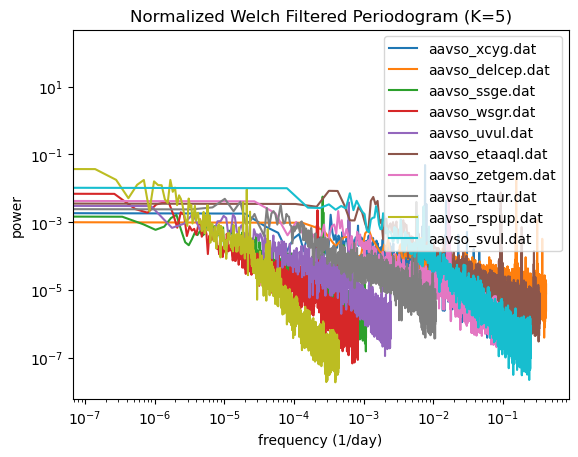

In [4]:
for c in cepheids:
    plt.loglog(c[0], c[1], label=c[2])
    plt.xlabel("frequency (1/day)")
    plt.ylabel("power")
    plt.title("Normalized Welch Filtered Periodogram (K=5)")
    plt.legend()

In [5]:
# # calculating and checking slope
# # obviously not correct

# c = cepheids[1]

# max = (c[0] > 0.003).argmax()
# log_slope = (np.log10(c[0][-1]) - np.log10(c[0][max])) / (np.log10(c[1][-1]) - np.log10(c[1][max]))
# log_slope 

# plt.loglog(c[0], c[1], label=c[2])
# plt.xlabel("frequency (1/day)")
# plt.ylabel("power")
# plt.title("Visually Checking Slope")

# line_x = c[0][max:-1]
# line_y = c[1][max] * (line_x / c[0][max])**log_slope

# plt.plot(line_x, line_y, label=f"Computed Slope: {log_slope}", color='orange', linestyle='--')
# plt.axvline(c[0][max], color='k', linestyle='--')

# plt.legend()

In [6]:
# # dividing by the line, whatever that means
# # definitely not correct
# c = cepheids[1]

# max = (c[0] > 0.003).argmax()
# log_slope = (np.log10(c[0][-1]) - np.log10(c[0][max])) / (np.log10(c[1][-1]) - np.log10(c[1][max]))
# log_slope 

# line_x = c[0][max:-1]
# line_y = c[1][max] * (line_x / c[0][max])**log_slope
# c[1][max:-1] = c[1][max:-1] / line_y

# plt.loglog(c[0], c[1], label=c[2])
# plt.xlabel("frequency (1/day)")
# plt.ylabel("power")
# plt.title("Visually Checking Slope")

# plt.plot(line_x, line_y, label=f"Computed Slope: {log_slope}", color='orange', linestyle='--')
# plt.axvline(c[0][max], color='k', linestyle='--')

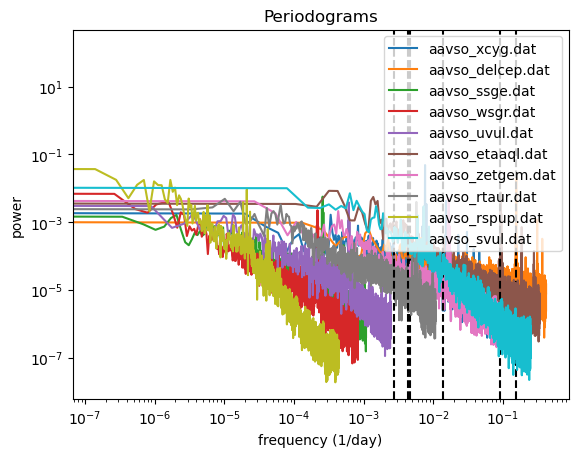

In [7]:
peaks = []

for c in cepheids:

    plt.loglog(c[0], c[1], label=c[2])
    plt.xlabel("frequency (1/day)")
    plt.ylabel("power")
    plt.title("Periodograms")


    max = (c[0] > 0.003).argmax()
    peak = np.argmax(c[1][max:-1])
    plt.axvline(c[0][peak], color='k', linestyle='--')
    plt.legend()

    peaks.append(c[0][peak])

peaks = np.array(peaks)

In [8]:
peaks

array([0.00462228, 0.15222328, 0.        , 0.        , 0.        ,
       0.08997615, 0.01369355, 0.00272712, 0.        , 0.00429663])

**c)** You will also need the average absolute magnitudes of the stars, based mostly on Hipparcos and Gaia parallax measurements:

| Star | $M_V$ (mag) | |  Star | $M_V$ (mag)|
| ---- | :-----: | - | ---- | :-----: |
| $\delta$ Cep | $-$3.47 | | S Vul | $-$6.08 |
| $\eta$ Aql | $-$3.70 | | U Vul | $-$3.69 |
| RS Pup | $-$5.70 | | W Sgr | $-$3.76 |
| RT Aur | $-$3.09 | | X Cyg | $-$4.46 |
| S Sge | $-$3.8 | | $\zeta$ Gem | $-$3.99 |

Print your results array as a nicely formatted table containing the absolute magnitudes and periods
for all the Cepheids.  

[3 pts]

In [9]:
absmags = np.array([3.47, 3.70, 5.70, 3.09, 3.8, -6.08, -3.69, -3.76, -4.46, -3.99])

print("{peak:9} {mag:5}".format(peak="Peak", mag="Mag"))
for peak, mag in list(zip(peaks, absmags)):
    print("{peak:9.3f} {mag:5.3f}".format(peak=1/peak, mag=mag))

Peak      Mag  
  216.343 3.470
    6.569 3.700
      inf 5.700
      inf 3.090
      inf 3.800
   11.114 -6.080
   73.027 -3.690
  366.688 -3.760
      inf -4.460
  232.741 -3.990


/var/folders/41/_gkgvhb94wd4156zplzr4cg00000gn/T/ipykernel_63424/1050458554.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  print("{peak:9.3f} {mag:5.3f}".format(peak=1/peak, mag=mag))


**d)** Create a scatter plot of the periods you have computed versus the absolute magnitudes from
the table above, and overplot the Benedict et al. period-luminosity relation. You should
be able to see a tight correlation between the two quantities which appears as a line on a
log-linear plot. Hooray! Henrietta Leavitt was right, and you’re off to the races!

[10 pts]

$$ M_V = (-2.43 \pm 0.12) (\log_{10} P - 1) - (4.05 \pm 0.02)$$

In [16]:
p = np.linspace(1, 100, 125)
Mv = (-2.43 * np.log10(p - 1)) - 4.05

/var/folders/41/_gkgvhb94wd4156zplzr4cg00000gn/T/ipykernel_63424/2346218849.py:2: RuntimeWarning: divide by zero encountered in log10
  Mv = (-2.43 * np.log10(p - 1)) - 4.05


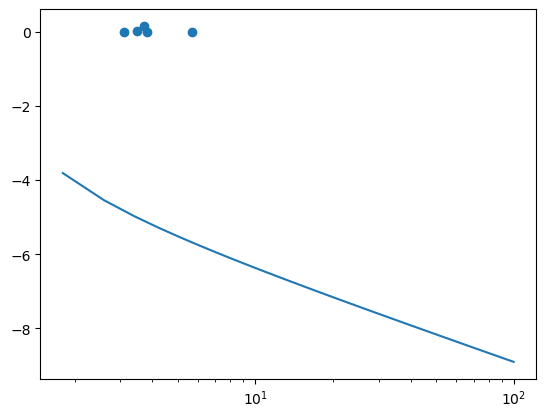

In [17]:
plt.scatter(absmags, peaks)
plt.plot(p, Mv)
plt.xscale('log')